# Data Generation Pipeline — Fine-Grained Sans-Serif Recognition

This notebook generates synthetic text images using **TextRecognitionDataGenerator (TRDG)** for **20 popular sans-serif font families**. Each image contains a short text phrase rendered in one of the target fonts on a clean white background — simulating web / digital poster screenshots.

**Pipeline steps:**
1. Install dependencies & configure paths
2. Build a reproducible text corpus
3. Generate images per font class using TRDG (varied sizes & colors)
4. Split into **80 / 20** train / test sets
5. Verify dataset statistics & preview samples

In [1]:
!python -m pip install "pip<24.1" -q
!pip install trdg -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Reason for being yanked: Doesn't work with Python 2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 15.0 MB/s eta 0:00:00


In [2]:
import os
import random
import shutil
from glob import glob
from collections import defaultdict

import numpy as np
from PIL import Image
from tqdm import tqdm

from trdg.generators import GeneratorFromStrings
import trdg.utils
import matplotlib.pyplot as plt

# Pillow 10 removed getsize(); TRDG still calls it internally.
# getbbox() returns (left, top, right, bottom) where top can be negative.
# To match old getsize() behaviour we must use `bottom` (not bottom-top)
# so the full glyph height including descenders is preserved.
def _patched_get_text_height(image_font, text):
    bbox = image_font.getbbox(text)
    return bbox[3]          # bottom: full height from origin

def _patched_get_text_width(image_font, text):
    bbox = image_font.getbbox(text)
    return bbox[2]          # right: full width from origin

trdg.utils.get_text_height = _patched_get_text_height
trdg.utils.get_text_width  = _patched_get_text_width

# Also patch the module that already imported the old functions
import trdg.computer_text_generator as _ctg
_ctg.get_text_height = _patched_get_text_height
_ctg.get_text_width  = _patched_get_text_width

2026-03-01 07:02:53.615871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772348573.981899      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772348574.073128      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772348574.912922      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772348574.912979      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772348574.912982      17 computation_placer.cc:177] computation placer alr

## 1 · Configuration & Setup

Define the font registry, output paths, and generation hyper-parameters.  
Paths **auto-detect** whether we are running on Kaggle or locally.

In [3]:
# Environment Detection
IS_KAGGLE = os.path.exists("/kaggle")
print(f"Running on: {'Kaggle' if IS_KAGGLE else 'Local'}")

if IS_KAGGLE:
    FONT_DIR    = "/kaggle/input/datasets/aristelcrowley/sans-serif-raw-fonts"  # ← Kaggle dataset name
    BASE_OUTPUT = "/kaggle/working/processed"
else:
    FONT_DIR    = "../data/raw_fonts"
    BASE_OUTPUT = "../data/processed"

TRAIN_DIR = os.path.join(BASE_OUTPUT, "train")
TEST_DIR  = os.path.join(BASE_OUTPUT, "test")
TEMP_DIR  = os.path.join(BASE_OUTPUT, "_all")   

# Font Registry
FONTS = {
    "DMSans":      "DMSans-Regular.ttf",
    "Figtree":     "Figtree-Regular.ttf",
    "FiraSans":    "FiraSans-Regular.ttf",
    "Heebo":       "Heebo-Regular.ttf",
    "Hind":        "Hind-Regular.ttf",
    "Inter":       "Inter-Regular.ttf",
    "Karla":       "Karla-Regular.ttf",
    "Lato":        "Lato-Regular.ttf",
    "Montserrat":  "Montserrat-Regular.ttf",
    "Mulish":      "Mulish-Regular.ttf",
    "NotoSans":    "NotoSans-Regular.ttf",
    "OpenSans":    "OpenSans-Regular.ttf",
    "Poppins":     "Poppins-Regular.ttf",
    "PTSans":      "PTSans-Regular.ttf",
    "Raleway":     "Raleway-Regular.ttf",
    "Roboto":      "Roboto-Regular.ttf",
    "Rubik":       "Rubik-Regular.ttf",
    "SourceSans3": "SourceSans3-Regular.ttf",
    "Ubuntu":      "Ubuntu-Regular.ttf",
    "WorkSans":    "WorkSans-Regular.ttf",
}

# Generation Parameters 
IMAGES_PER_CLASS = 5000
TRAIN_RATIO      = 0.8         
RANDOM_SEED      = 42
SIZES       = [32, 48, 64, 80, 96]
TEXT_COLORS = ["#000000", "#1a1a1a", "#333333", "#4a4a4a"]

# Verify Fonts

missing = [f for f in FONTS.values() if not os.path.isfile(os.path.join(FONT_DIR, f))]
if missing:
    raise FileNotFoundError(f"Missing font files in {FONT_DIR}: {missing}")

print(f"✓ All {len(FONTS)} font files found in {FONT_DIR}")
print(f"  Images per class : {IMAGES_PER_CLASS}")
print(f"  Total images     : {IMAGES_PER_CLASS * len(FONTS):,}")
print(f"  Train / Test     : {TRAIN_RATIO:.0%} / {1 - TRAIN_RATIO:.0%}")

Running on: Kaggle
✓ All 20 font files found in /kaggle/input/datasets/aristelcrowley/sans-serif-raw-fonts
  Images per class : 5000
  Total images     : 100,000
  Train / Test     : 80% / 20%


## 2 · Text Corpus

A pool of **120 common English words** (web / UI / tech themed) is randomly combined into 1–5 word phrases.  

In [4]:
WORD_POOL = [
    "the", "quick", "brown", "fox", "jumps", "over", "lazy", "dog",
    "hello", "world", "from", "with", "this", "that", "have", "been",
    "will", "your", "about", "more", "when", "which", "their", "what",
    "design", "modern", "creative", "digital", "website", "portfolio",
    "services", "products", "features", "pricing", "contact", "gallery",
    "home", "blog", "news", "events", "team", "careers", "support",
    "learn", "explore", "discover", "subscribe", "download", "search",
    "settings", "profile", "login", "register", "welcome", "dashboard",
    "analytics", "navigation", "header", "footer", "sidebar", "content",
    "innovation", "technology", "platform", "system", "software",
    "algorithm", "database", "framework", "interface", "network",
    "security", "cloud", "machine", "learning", "artificial",
    "intelligence", "automation", "optimize", "scalable", "robust",
    "company", "business", "startup", "enterprise", "agency",
    "strategy", "marketing", "branding", "growth", "revenue",
    "customer", "solution", "premium", "standard", "professional",
    "beautiful", "minimal", "elegant", "simple", "clean", "bold",
    "dynamic", "responsive", "seamless", "powerful", "intuitive",
    "efficient", "reliable", "flexible", "innovative", "sustainable",
    "experience", "performance", "development", "engineering", "research",
    "education", "community", "global", "future", "vision", "mission",
    "quality", "excellence", "progress", "success", "journey",
    "transform", "connect", "build", "create", "launch", "deliver",
]

def build_text_corpus(n: int, seed: int = 42) -> list[str]:
    rng = random.Random(seed)
    texts = []
    for _ in range(n):
        num_words = rng.randint(1, 5)
        phrase = " ".join(rng.choices(WORD_POOL, k=num_words))
        r = rng.random()
        if r < 0.35:
            phrase = phrase.title()     
        elif r < 0.50:
            phrase = phrase.upper()      
        texts.append(phrase)
    return texts

_preview = build_text_corpus(8, seed=RANDOM_SEED)
for t in _preview:
    print(f"  \"{t}\"")

  "Fox"
  "about that"
  "With Navigation Fox Portfolio Database"
  "PROFESSIONAL PREMIUM"
  "optimize reliable the efficient"
  "Blog Website Dynamic"
  "this performance robust reliable"
  "will quality from events enterprise"


## 3 · Image Generation with TRDG

For each of the 20 font classes, **5,000 images** are generated using a **multi-profile strategy** that mirrors the realistic distribution of how text appears in screenshots and photographs of digital content.

In [5]:
import io

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Each profile = (name, share, background_type, skewing_angle, random_skew, blur, random_blur, text_colors)
# background_type: 0 = Gaussian noise, 1 = plain white, 2 = quasicrystal

PROFILES = [
    ("clean",          0.40,  1,  0,    False,  0,   False,  ["#000000", "#111111", "#1a1a1a"]),
    ("light_noise",    0.15,  0,  0,    False,  0,   False,  ["#000000", "#1a1a1a"]),
    ("light_skew",     0.10,  1,  3,    True,   0,   False,  ["#000000", "#222222"]),
    ("light_blur",     0.10,  1,  0,    False,  1,   True,   ["#000000", "#1a1a1a"]),
    ("combined_mild",  0.10,  0,  2,    True,   1,   True,   ["#000000", "#1a1a1a", "#333333"]),
    ("offwhite_bg",    0.10,  2,  0,    False,  0,   False,  ["#000000", "#222222", "#333333"]),
    ("grey_text",      0.05,  1,  0,    False,  0,   False,  ["#555555", "#666666", "#777777"]),
]

# Post-Processing 

POST_PROCESS_RATIO = 0.30  # apply to 30% of all images
DARK_MODE_RATIO    = 0.20  # invert 20% of images to simulate dark mode

def post_process(img: Image.Image, rng: random.Random) -> Image.Image:
    """Randomly apply lightweight real-world capture artifacts."""
    img = img.convert("RGB")

    # 1) JPEG compression artifact (50% chance within the 30%)
    if rng.random() < 0.50:
        quality = rng.randint(60, 95)
        buf = io.BytesIO()
        img.save(buf, format="JPEG", quality=quality)
        buf.seek(0)
        img = Image.open(buf).copy()

    # 2) Brightness & contrast jitter (60% chance)
    if rng.random() < 0.60:
        from PIL import ImageEnhance
        # Brightness: 0.90 – 1.10
        brightness_factor = rng.uniform(0.90, 1.10)
        img = ImageEnhance.Brightness(img).enhance(brightness_factor)
        # Contrast: 0.90 – 1.10
        contrast_factor = rng.uniform(0.90, 1.10)
        img = ImageEnhance.Contrast(img).enhance(contrast_factor)

    # 3) Sparse salt-and-pepper noise (40% chance)
    if rng.random() < 0.40:
        arr = np.array(img)
        num_pixels = arr.shape[0] * arr.shape[1]
        num_salt = int(num_pixels * rng.uniform(0.001, 0.005))
        for _ in range(num_salt):
            y = rng.randint(0, arr.shape[0] - 1)
            x = rng.randint(0, arr.shape[1] - 1)
            arr[y, x] = 255 if rng.random() < 0.5 else 0
        img = Image.fromarray(arr)

    return img


texts = build_text_corpus(IMAGES_PER_CLASS, seed=RANDOM_SEED)

print(f"Generating {IMAGES_PER_CLASS} images × {len(FONTS)} fonts "
      f"= {IMAGES_PER_CLASS * len(FONTS):,} total")
print(f"  {len(PROFILES)} augmentation profiles")
print(f"  Post-processing on ~{POST_PROCESS_RATIO:.0%} of images")
print(f"  Dark mode inversion on ~{DARK_MODE_RATIO:.0%} of images\n")


aug_rng = random.Random(RANDOM_SEED + 1) 

for font_name, font_file in tqdm(FONTS.items(), desc="Fonts", unit="font"):
    font_path = os.path.join(FONT_DIR, font_file)
    out_dir   = os.path.join(TEMP_DIR, font_name)
    os.makedirs(out_dir, exist_ok=True)

    img_idx = 0
    text_cursor = 0 

    for prof_name, share, bg_type, skew_angle, r_skew, blur_val, r_blur, colors in PROFILES:
        prof_count = int(IMAGES_PER_CLASS * share)

        # Distribute this profile's images evenly across all sizes
        per_size = prof_count // len(SIZES)
        remainder = prof_count - per_size * len(SIZES)

        for size_i, size in enumerate(SIZES):
            batch_n = per_size + (1 if size_i < remainder else 0)
            if batch_n == 0:
                continue

            batch_texts = texts[text_cursor : text_cursor + batch_n]
            text_cursor = (text_cursor + batch_n) % len(texts)
            color = colors[size_i % len(colors)]

            generator = GeneratorFromStrings(
                strings=batch_texts,
                fonts=[font_path],
                count=batch_n,
                size=size,
                skewing_angle=skew_angle,
                random_skew=r_skew,
                blur=blur_val,
                random_blur=r_blur,
                background_type=bg_type,
                text_color=color,
                margins=(5, 5, 5, 5),
                fit=True,
            )
            for img, _ in generator:
                # Post-processing artifacts (~30%)
                if aug_rng.random() < POST_PROCESS_RATIO:
                    img = post_process(img, aug_rng)

                # Dark mode inversion (~20%) — light text on dark background
                if aug_rng.random() < DARK_MODE_RATIO:
                    from PIL import ImageOps
                    img = ImageOps.invert(img.convert("RGB"))


                img.save(os.path.join(out_dir, f"{font_name}_{img_idx:05d}.png"))
                img_idx += 1

    tqdm.write(f"  ✓ {font_name:<14s} — {img_idx} images saved")
    
print(f"\n✓ Generation complete: {IMAGES_PER_CLASS * len(FONTS):,} images → {TEMP_DIR}")

Generating 5000 images × 20 fonts = 100,000 total
  7 augmentation profiles
  Post-processing on ~30% of images
  Dark mode inversion on ~20% of images



Fonts:   5%|▌         | 1/20 [05:57<1:53:04, 357.08s/font]

  ✓ DMSans         — 5000 images saved


Fonts:  10%|█         | 2/20 [11:12<1:39:42, 332.34s/font]

  ✓ Figtree        — 5000 images saved


Fonts:  15%|█▌        | 3/20 [17:36<1:40:53, 356.11s/font]

  ✓ FiraSans       — 5000 images saved


Fonts:  20%|██        | 4/20 [22:52<1:30:45, 340.36s/font]

  ✓ Heebo          — 5000 images saved


Fonts:  25%|██▌       | 5/20 [28:38<1:25:35, 342.37s/font]

  ✓ Hind           — 5000 images saved


Fonts:  30%|███       | 6/20 [34:24<1:20:10, 343.57s/font]

  ✓ Inter          — 5000 images saved


Fonts:  35%|███▌      | 7/20 [39:41<1:12:32, 334.80s/font]

  ✓ Karla          — 5000 images saved


Fonts:  40%|████      | 8/20 [45:18<1:07:05, 335.46s/font]

  ✓ Lato           — 5000 images saved


Fonts:  45%|████▌     | 9/20 [51:54<1:05:00, 354.57s/font]

  ✓ Montserrat     — 5000 images saved


Fonts:  50%|█████     | 10/20 [57:13<57:14, 343.42s/font] 

  ✓ Mulish         — 5000 images saved


Fonts:  55%|█████▌    | 11/20 [1:03:31<53:08, 354.23s/font]

  ✓ NotoSans       — 5000 images saved


Fonts:  60%|██████    | 12/20 [1:09:41<47:50, 358.77s/font]

  ✓ OpenSans       — 5000 images saved


Fonts:  65%|██████▌   | 13/20 [1:14:56<40:19, 345.59s/font]

  ✓ Poppins        — 5000 images saved


Fonts:  70%|███████   | 14/20 [1:20:08<33:33, 335.57s/font]

  ✓ PTSans         — 5000 images saved


Fonts:  75%|███████▌  | 15/20 [1:26:07<28:33, 342.62s/font]

  ✓ Raleway        — 5000 images saved


Fonts:  80%|████████  | 16/20 [1:32:14<23:19, 349.83s/font]

  ✓ Roboto         — 5000 images saved


Fonts:  85%|████████▌ | 17/20 [1:37:45<17:12, 344.29s/font]

  ✓ Rubik          — 5000 images saved


Fonts:  90%|█████████ | 18/20 [1:42:55<11:07, 333.82s/font]

  ✓ SourceSans3    — 5000 images saved


Fonts:  95%|█████████▌| 19/20 [1:48:24<05:32, 332.43s/font]

  ✓ Ubuntu         — 5000 images saved


Fonts: 100%|██████████| 20/20 [1:54:05<00:00, 342.27s/font]

  ✓ WorkSans       — 5000 images saved

✓ Generation complete: 100,000 images → /kaggle/working/processed/_all


## 4 · Train / Test Split

Shuffle each class and split **80 / 20** into `train/` and `test/` directories.  
The temporary `_all/` staging folder is removed afterwards to save disk space.

In [6]:
random.seed(RANDOM_SEED)

# Create output directories
for font_name in FONTS:
    os.makedirs(os.path.join(TRAIN_DIR, font_name), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR,  font_name), exist_ok=True)

print("Splitting dataset …\n")

train_total = 0
test_total  = 0

for font_name in sorted(FONTS.keys()):
    src_dir = os.path.join(TEMP_DIR, font_name)
    images  = sorted(glob(os.path.join(src_dir, "*.png")))
    random.shuffle(images)

    split_idx  = int(len(images) * TRAIN_RATIO)
    train_imgs = images[:split_idx]
    test_imgs  = images[split_idx:]

    for img_path in train_imgs:
        shutil.copy2(img_path, os.path.join(TRAIN_DIR, font_name, os.path.basename(img_path)))
    for img_path in test_imgs:
        shutil.copy2(img_path, os.path.join(TEST_DIR,  font_name, os.path.basename(img_path)))

    train_total += len(train_imgs)
    test_total  += len(test_imgs)
    print(f"  {font_name:<14s} — train: {len(train_imgs):>4d}   test: {len(test_imgs):>3d}")

# Clean up staging directory
shutil.rmtree(TEMP_DIR)

print(f"\n✓ Split complete")
print(f"  Train : {train_total:,} images → {TRAIN_DIR}")
print(f"  Test  : {test_total:,} images  → {TEST_DIR}")

Splitting dataset …

  DMSans         — train: 4000   test: 1000
  Figtree        — train: 4000   test: 1000
  FiraSans       — train: 4000   test: 1000
  Heebo          — train: 4000   test: 1000
  Hind           — train: 4000   test: 1000
  Inter          — train: 4000   test: 1000
  Karla          — train: 4000   test: 1000
  Lato           — train: 4000   test: 1000
  Montserrat     — train: 4000   test: 1000
  Mulish         — train: 4000   test: 1000
  NotoSans       — train: 4000   test: 1000
  OpenSans       — train: 4000   test: 1000
  PTSans         — train: 4000   test: 1000
  Poppins        — train: 4000   test: 1000
  Raleway        — train: 4000   test: 1000
  Roboto         — train: 4000   test: 1000
  Rubik          — train: 4000   test: 1000
  SourceSans3    — train: 4000   test: 1000
  Ubuntu         — train: 4000   test: 1000
  WorkSans       — train: 4000   test: 1000

✓ Split complete
  Train : 80,000 images → /kaggle/working/processed/train
  Test  : 20,000 images

## 5 · Dataset Verification

Count images per class in both splits and display one random sample per font.

 DATASET SUMMARY

  Train set:
    DMSans        : 4000
    Figtree       : 4000
    FiraSans      : 4000
    Heebo         : 4000
    Hind          : 4000
    Inter         : 4000
    Karla         : 4000
    Lato          : 4000
    Montserrat    : 4000
    Mulish        : 4000
    NotoSans      : 4000
    OpenSans      : 4000
    PTSans        : 4000
    Poppins       : 4000
    Raleway       : 4000
    Roboto        : 4000
    Rubik         : 4000
    SourceSans3   : 4000
    Ubuntu        : 4000
    WorkSans      : 4000
    TOTAL         : 80000

  Test set:
    DMSans        : 1000
    Figtree       : 1000
    FiraSans      : 1000
    Heebo         : 1000
    Hind          : 1000
    Inter         : 1000
    Karla         : 1000
    Lato          : 1000
    Montserrat    : 1000
    Mulish        : 1000
    NotoSans      : 1000
    OpenSans      : 1000
    PTSans        : 1000
    Poppins       : 1000
    Raleway       : 1000
    Roboto        : 1000
    Rubik         : 1000
    S

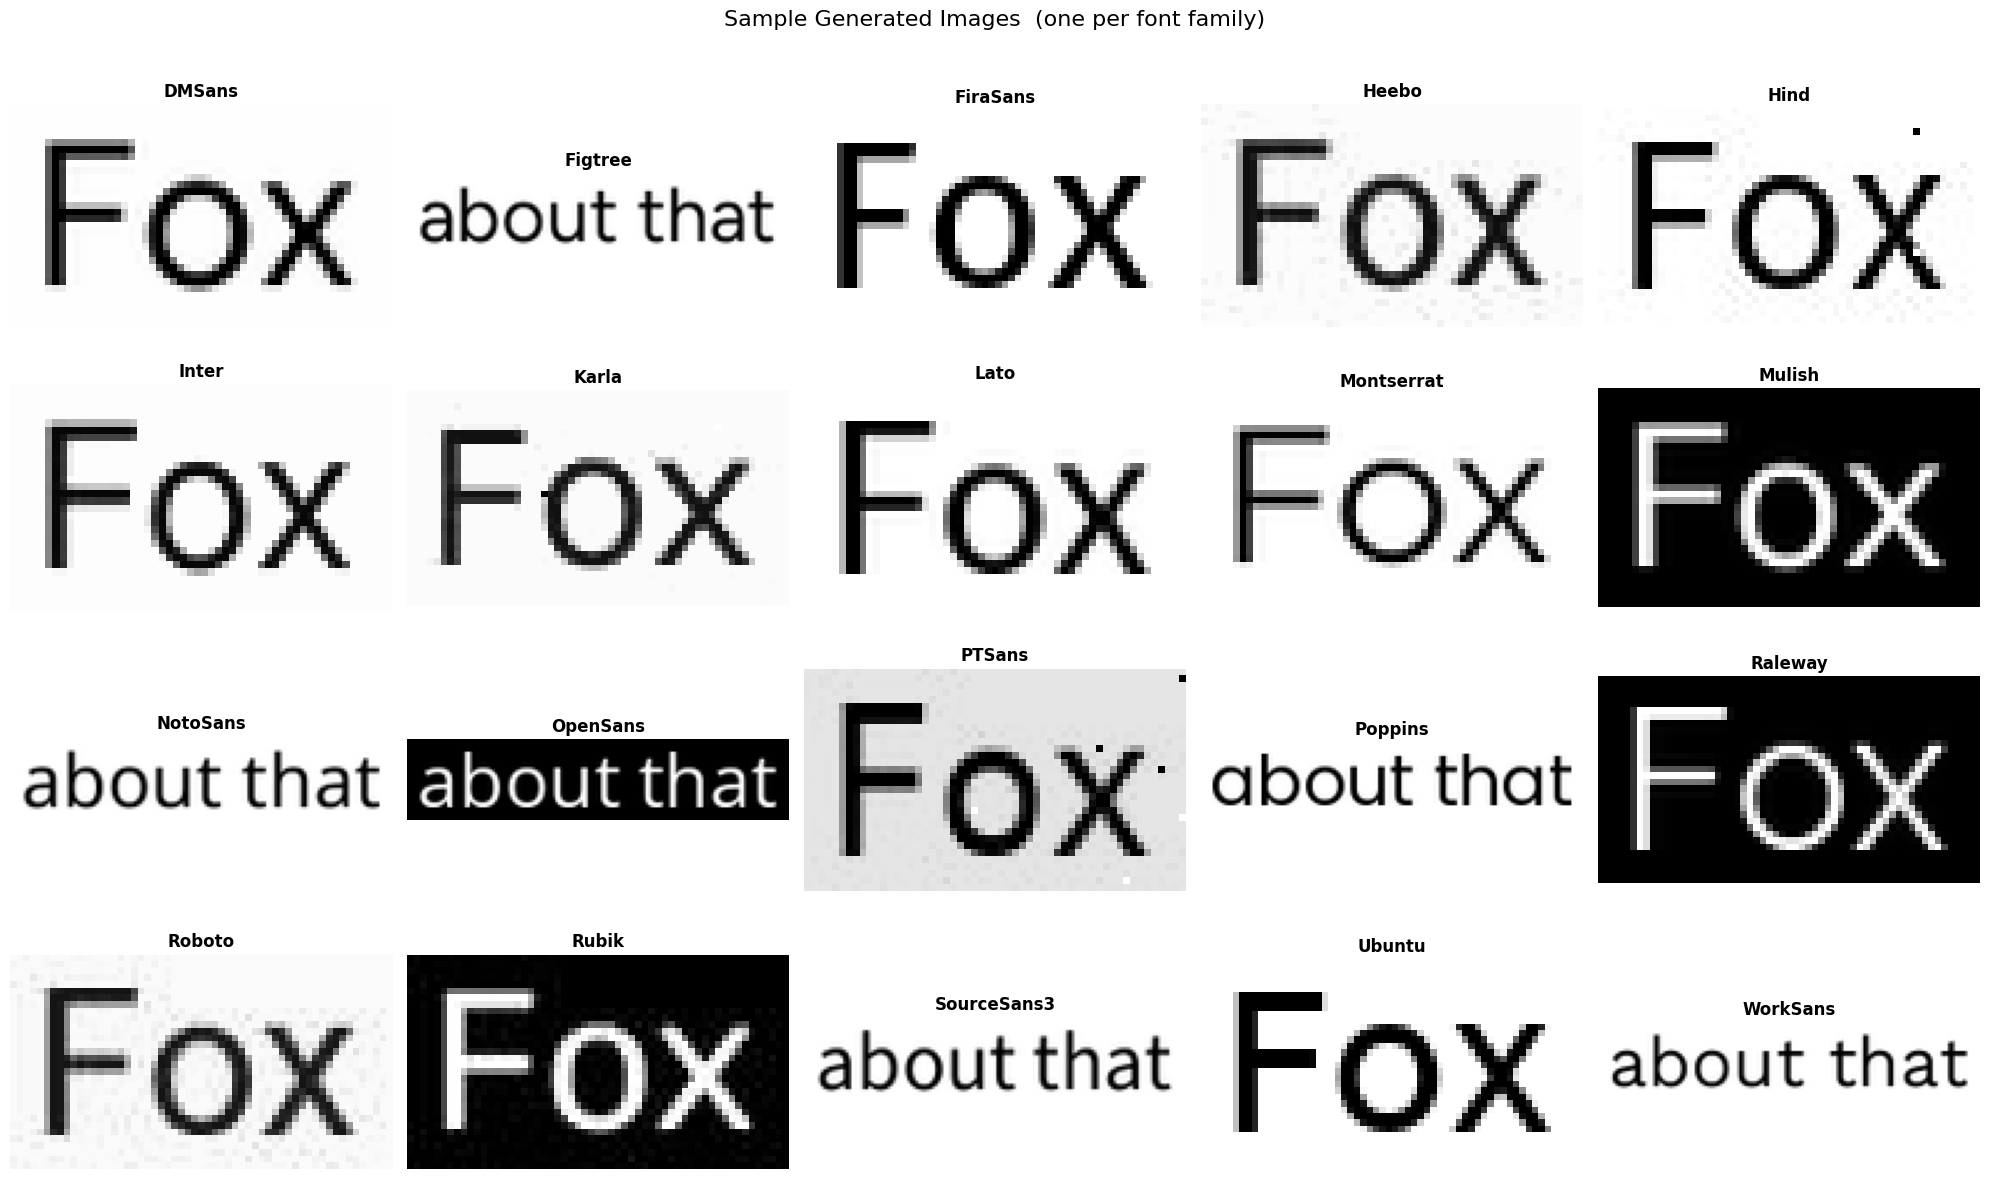

In [7]:
# Per-class counts
print(" DATASET SUMMARY")

for split_name, split_dir in [("Train", TRAIN_DIR), ("Test", TEST_DIR)]:
    print(f"\n  {split_name} set:")
    total = 0
    for font_name in sorted(FONTS.keys()):
        count = len(glob(os.path.join(split_dir, font_name, "*.png")))
        total += count
        print(f"    {font_name:<14s}: {count}")
    print(f"    {'TOTAL':<14s}: {total}")

# Sample grid
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
fig.suptitle("Sample Generated Images  (one per font family)", fontsize=16, y=1.01)

for idx, font_name in enumerate(sorted(FONTS.keys())):
    ax = axes[idx // 5, idx % 5]
    sample_dir  = os.path.join(TRAIN_DIR, font_name)
    sample_imgs = sorted(glob(os.path.join(sample_dir, "*.png")))
    if sample_imgs:
        img = Image.open(sample_imgs[0])
        ax.imshow(img)
    ax.set_title(font_name, fontsize=12, fontweight="bold")
    ax.axis("off")

plt.tight_layout()
plt.show()

## 6 · Export (Kaggle only)

Zip the processed dataset so it can be downloaded from Kaggle or attached to another notebook as a dataset.

In [8]:
if IS_KAGGLE:
    import zipfile

    zip_path = "/kaggle/working/sans_serif_dataset.zip"
    print("Creating zip archive …")

    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(BASE_OUTPUT):
            for fname in files:
                full = os.path.join(root, fname)
                arcname = os.path.relpath(full, BASE_OUTPUT)
                zf.write(full, arcname)

    size_mb = os.path.getsize(zip_path) / (1024 * 1024)
    print(f"✓ Saved {zip_path}  ({size_mb:.1f} MB)")
else:
    print("Skipping zip — not running on Kaggle.")

Creating zip archive …
✓ Saved /kaggle/working/sans_serif_dataset.zip  (3176.3 MB)
